# Inference Homework 5
## Alex Pine
## 2015/11/21

In [ ]:
# TODO Question 1, 3

# Question 2

In [ ]:
# DONE Read the input file into a 4367x111 (pictures, objects) matrix 
# DONE Create a 111x111 triangular (ie sparse) matrix that contains the counts of the object pair cooccurances.
# DONE Create another triangular matrix of the same dimension that contains the mutual empirical information,
#      using the formula given.
# DONE invert everything to do the max tree instead
# DONE Feed this into Kruskal's/Prim's for maximum weight tree. (scipy.sparse.csgraph.minimum_spanning_tree)
# DONE Parse this tree into debugging output with the labels (with pydot?), as a sanity check
# TODO Parse the tree output into the output format 
# TODO Read in the file that maps object indexes to their labels, for testing

In [520]:
import numpy as np

def read_chowlui_input():
    input_matrix = []
    with open('inference/hw5/data/chowliu-input.txt', 'r') as f:
        for line in f:
            input_matrix.append([int(token) for token in line.split()])
    return np.array(input_matrix)        

def read_labels_input():
    input_labels = []
    with open('inference/hw5/data/names.txt', 'r') as f:
        for line in f:
            input_labels.append(line.strip())
    return np.array(input_labels)

input_matrix = read_chowlui_input()
labels = read_labels_input()

In [618]:
import scipy.sparse.csgraph

def create_count_matrices(input_matrix):
    # g[i][j] = n, the number of times items i and j were both present. triangular. 
    both_count_matrix = np.zeros((input_matrix.shape[1], input_matrix.shape[1]), dtype=int)
    # h[i][j] = n, the number of times item i was present and j was not.
    single_count_matrix = np.zeros((input_matrix.shape[1], input_matrix.shape[1]), dtype=int)
    for row in input_matrix:
        for i in range(len(row)):
            for j in range(len(row)):
                if i > j and row[i] == 1 and row[j] == 1:
                    both_count_matrix[i][j] += 1
                if row[i] == 1 and row[j] == 0: 
                    single_count_matrix[i][j] += 1
            if row[i] == 1:
                both_count_matrix[i][i] += 1
            #else: # TODO not sure this is necessary or correct
            #    single_count_matrix[i][i] += 1
    return both_count_matrix, single_count_matrix

both_count_matrix, single_count_matrix = create_count_matrices(input_matrix)
num_data = input_matrix.shape[0]

In [642]:
import itertools
import numpy.ma as ma    
    
# Computes one part of the sum of the "empirical" mutual information between x_i and x_j.
def mutual_info_part(num_xixj, num_xi, num_xj, total):
    if not num_xixj or not num_xi or not num_xj:
        return 0.0
    p_xixj = 1.0 * num_xixj / total
    p_xi = 1.0 * num_xi / total
    p_xj = 1.0 * num_xj / total
    return p_xixj * math.log(p_xixj / (p_xi * p_xj), 2)


def mutual_info(i, j, num_data, both_count_matrix, single_count_matrix):
    num_xi_one = both_count_matrix[i][i]  
    num_xj_one = both_count_matrix[j][j]
    num_xi_zero = num_data - num_xi_one
    num_xj_zero = num_data - num_xj_one    
    info = 0.0
    # 11 case
    info += mutual_info_part(both_count_matrix[i][j], num_xi_one, num_xj_one, num_data)
    # 10 case
    info += mutual_info_part(single_count_matrix[i][j], num_xi_one, num_xj_zero, num_data)
    # 01 case
    info += mutual_info_part(single_count_matrix[j][i], num_xi_zero, num_xj_one, num_data)
    # 00 case
    neither_count = num_data - both_count_matrix[i][j] - single_count_matrix[i][j] - single_count_matrix[j][i]
    info += mutual_info_part(neither_count, num_xi_zero, num_xj_zero, num_data)
    assert neither_count + both_count_matrix[i][j] + single_count_matrix[i][j] + single_count_matrix[j][i] == num_data
    return info
    
# Create a matrix where each value is the inverse of the mutual information values between each item.
# Taking the inverse so that a minimum-spanning tree algo will find the maximum-spanning tree instead.
def create_inv_mutual_info_matrix(num_data, both_count_matrix, single_count_matrix):
    inv_info_matrix = np.zeros(both_count_matrix.shape)
    # Create a mask for the upper right corner, to mark this matrix as triangular.
    info_mask = np.zeros(both_count_matrix.shape, dtype=int)
    num_items = both_count_matrix.shape[1]
    for i in range(num_items):
        for j in range(i):
            info = mutual_info(i, j, num_data, both_count_matrix, single_count_matrix)
            inv_info_matrix[i][j] = 1.0 / info
        for j in range(i, num_items):
            info_mask[i][j] = 1
    inv_info_matrix = ma.array(inv_info_matrix, mask=info_mask)
    return inv_info_matrix


inv_info_matrix = create_inv_mutual_info_matrix(num_data, both_count_matrix, single_count_matrix)
inv_info_matrix

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [186703.44152668215 -- -- ..., -- -- --]
 [4020.84699457407 992.509768919303 -- ..., -- -- --]
 ..., 
 [292.37122163717805 30.470142647214498 115.69314336477676 ..., -- -- --]
 [147667.19693943995 603.544911431266 971.9073084792378 ...,
  60.289042237686736 -- --]
 [1095.9445385710844 203.87774138815544 168.83512909393508 ...,
  56.14674857776335 150.09678783760322 --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [False  True  True ...,  True  True  True]
 [False False  True ...,  True  True  True]
 ..., 
 [False False False ...,  True  True  True]
 [False False False ..., False  True  True]
 [False False False ..., False False  True]],
       fill_value = 1e+20)

In [643]:
import scipy.sparse.csgraph

mst_rows, mst_columns = scipy.sparse.csgraph.minimum_spanning_tree(inv_info_matrix).nonzero()
mst_edge_pairs = zip(mst_rows, mst_columns)
for i, j in mst_edge_pairs:
    print i, j, labels[i], '--', labels[j]

13 11 books -- book
13 12 books -- bookcase
15 14 bottles -- bottle
18 17 boxes -- box
20 2 building -- awning
20 4 building -- balcony
22 16 cabinet -- bowl
25 24 cars -- car
32 22 countertop -- cabinet
35 8 cushion -- bed
36 26 desk -- chair
36 28 desk -- clock
39 20 dome -- building
40 6 door -- bars
41 22 drawer -- cabinet
45 1 fireplace -- armchair
46 1 floor -- armchair
46 13 floor -- books
46 20 floor -- building
46 26 floor -- chair
46 27 floor -- chandelier
47 23 flowers -- candle
51 46 ground -- floor
52 40 handrail -- door
53 50 headstone -- grass
54 0 machine -- airplane
60 50 path -- grass
63 8 pillow -- bed
65 16 plate -- bowl
65 37 plate -- dish
66 9 platform -- bench
68 64 pot -- plant
69 40 railing -- door
70 33 refrigerator -- cupboard
71 46 river -- floor
72 0 road -- airplane
72 20 road -- building
72 21 road -- bus
72 24 road -- car
72 67 road -- poster
74 73 rocks -- rock
75 46 rug -- floor
77 36 screen -- desk
78 10 sea -- boat
78 46 sea -- floor
78 76 sea -- san

In [644]:

def edge_part(num_xixj, num_xi, num_xj, total):   
    p_xixj = 1.0 * num_xixj / total
    p_xi = 1.0 * num_xi / total
    p_xj = 1.0 * num_xj / total
    return p_xixj / (p_xi * p_xj)


def edge_potential(i, j, num_data, both_count_matrix, single_count_matrix):
    num_xi_one = both_count_matrix[i][i]  
    num_xj_one = both_count_matrix[j][j]
    num_xi_zero = num_data - num_xi_one
    num_xj_zero = num_data - num_xj_one
    potential = np.zeros((2, 2))
    # 11 case
    potential[1][1] = edge_part(both_count_matrix[i][j], num_xi_one, num_xj_one, num_data)
    # 10 case
    potential[1][0] = edge_part(single_count_matrix[i][j], num_xi_one, num_xj_zero, num_data)
    # 01 case
    potential[0][1] = edge_part(single_count_matrix[j][i], num_xi_zero, num_xj_one, num_data)
    # 00 case
    neither_count = num_data - both_count_matrix[i][j] - single_count_matrix[i][j] - single_count_matrix[j][i]
    potential[0][0] = edge_part(neither_count, num_xi_zero, num_xj_zero, num_data)
    assert neither_count + both_count_matrix[i][j] + single_count_matrix[i][j] + single_count_matrix[j][i] == num_data
    return potential


def node_potential(i, num_data, both_count_matrix):
    num_xi_one = both_count_matrix[i][i]
    num_xi_zero = num_data - num_xi_one
    return np.array([float(num_xi_one) / num_data, float(num_xi_zero) / num_data]) 


def create_graph_potentials(mst_edge_pairs, num_data, both_count_matrix, single_count_matrix):
    # Every node i has a 1x2 potential matrix
    node_potentials = np.ndarray((both_count_matrix.shape[0], 2))
    # Every edge (i,j) has a 2x2 potential matrix.
    edge_potentials = np.ndarray((both_count_matrix.shape[0], both_count_matrix.shape[1], 2, 2))
    num_items = both_count_matrix.shape[1]
    for i in range(num_items):
        for j in range(i):
            edge_potentials[i][j] = edge_potential(i, j, num_data, both_count_matrix, single_count_matrix)
        node_potentials[i] = node_potential(i, num_data, both_count_matrix)
    return node_potentials, edge_potentials

node_potentials, edge_potentials = create_graph_potentials(mst_edge_pairs, num_data, 
                                                           both_count_matrix, single_count_matrix)

In [645]:

def create_graph_as_uai_file(mst_edge_pairs, node_potentials, edge_potentials):
    num_vars = node_potentials.shape[0]    
    
    network_type = 'MARKOV'
    num_vars_str = str(num_vars)
    var_cardinals = ' '.join(['2']*num_vars)
    num_cliques = str(len(mst_edge_pairs) + num_vars)
    node_cliques = ['1 ' + str(i) for i in range(num_vars)]
    edge_cliques = [' '.join(['2', str(i), str(j)]) for i, j in mst_edge_pairs]
    preamble = [network_type, num_vars_str, var_cardinals, num_cliques] + node_cliques + edge_cliques
    
    function_tables = []
    # node potentials
    for i in range(num_vars):
        prob_str = ' '.join([' ', str(node_potentials[i][0]), str(node_potentials[i][1])])
        function_tables += ['', '2', prob_str]
    # edge potentials
    for i, j in mst_edge_pairs:
        assert i > j
        prob00 = edge_potentials[i][j][0][0]
        prob01 = edge_potentials[i][j][0][1]
        prob_str1 = ' '.join([' ', str(prob00), str(prob01)])
        prob10 = edge_potentials[i][j][1][0]
        prob11 = edge_potentials[i][j][1][1]
        prob_str2 = ' '.join([' ', str(prob10), str(prob11)])
        function_tables += ['', '4', prob_str1, prob_str2]
    return '\n'.join(preamble + function_tables + [''])
        
uai_str = create_graph_as_uai_file(mst_edge_pairs, node_potentials, edge_potentials)

In [646]:
with open ('hw5_prob2.uai', 'w') as f:
    f.write(uai_str)

## Question 4
I collaborated with Peter Li on thsi problem.

I've graphed four covariance functions:

1) Exponential (not differentiable, not compact)

2) Squared Exponential (differentiable, not compact)

3) Spherical (not differentiable, compact)

4) Linear (differentiable, not compact)

In [435]:
# Covariance functions

import itertools
import math
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline  

# 1) Exponential (not differentiable, not compact)
def make_exp_covar_fn(tau, l):
    def exp_covar_fn(x, y):
        return tau**2 * math.exp(-np.linalg.norm(x - y) / (2*l))
    return exp_covar_fn

# 2) Squared Exponential (differentiable, not compact)
def make_squared_exp_covar_fn(tau, l):
    def squared_exp_covar_fn(x, y):
        diff = x - y
        return tau**2 * math.exp(-np.inner(diff, diff) / (2*(l**2)))
    return squared_exp_covar_fn

# 3) Spherical (not differentiable, compact)
def make_spherical_covar_fn(tau, theta):
    def spherical_covar_fn(x, y):
        dist = np.linalg.norm(x - y)
        if dist <= theta:
            return tau**2 * (1 - 3*dist/(2*theta) + dist**3/(2*theta**3))
        else:
            return 0.0
    return spherical_covar_fn

# 4) Linear (differentiable, not compact)
def make_linear_covar_fn(sigma, tau, c):
    def linear_covar_fn(x, y):
        return sigma**2 + tau**2 * np.inner(x - c, y - c)
    return linear_covar_fn


In [317]:
# This samples from a multivariate Gaussian distribution, with a zero mean 
# value, and a covariance matrix determined by the convariance function 
# and the x values parameters.
def sample_gp(xs, covar_fn):
    mean_vec = np.zeros(len(xs))
    gram_matrix = np.zeros((len(xs), len(xs)))
    for i in range(len(xs)):
        x_i = xs[i]
        for j in range(0, i):
            x_j = xs[j]
            gram_matrix[i][j] = covar_fn(x_i, x_j)
            gram_matrix[j][i] = gram_matrix[i][j]
        gram_matrix[i][i] = covar_fn(x_i, x_i)
    samples = np.random.multivariate_normal(mean_vec, gram_matrix)
    return samples
   

In [491]:
def plot_covar_fn(title, covar_fn_maker, param_list, param_names):
    covar_fn_list = [covar_fn_maker(*params) for params in param_list]
    ys = np.arange(0.0, 1.0, 0.01)
    
    covar_vals = []
    sample_vals = []
    for covar_fn in covar_fn_list:
        covar_vals.append([covar_fn(0.0, y) for y in ys])
        sample_vals.append(sample_gp(ys, covar_fn))
        
    fig = plt.figure(1, figsize=(18, 6))
    # Covariance values
    plt.subplot(1, 2, 1)
    plt.title(title + ': Covariance function values')
    plt.xlabel('y_i - x_i')
    plt.ylabel('covariance(x_i, y_i)')
    lines = []
    for params, covar_val in zip(param_list, covar_vals):
        param_str = ", ".join([name + ": " + str(param) 
                               for name, param in zip(param_names, params)])
        line, = plt.plot(ys, covar_val)
        lines.append(param_str)
    plt.legend(lines)
    # Gaussian Process samples
    plt.subplot(1, 2, 2)
    plt.title(title + ': GP Samples')
    for sample_val in sample_vals:
        plt.plot(ys, sample_val)
    plt.xlabel('y_i - x_i')
    plt.ylabel('Guassian Sample (x_i, y_i)')    
    plt.show()     

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


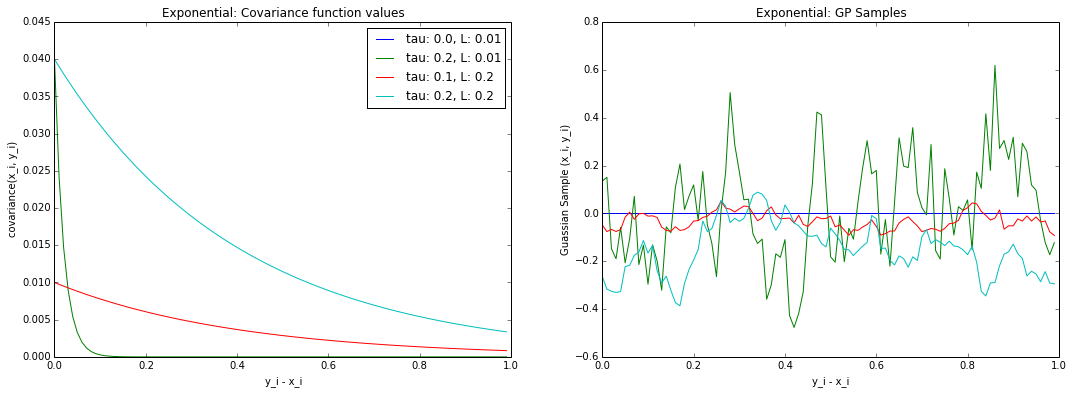

In [492]:
# L can't be zero or you get a divide by zero error
exp_params = [(0.0, 0.01), (0.2, 0.01), (0.1, 0.2), (0.2, 0.2)]
plot_covar_fn("Exponential", make_exp_covar_fn, exp_params, ['tau', 'L'])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


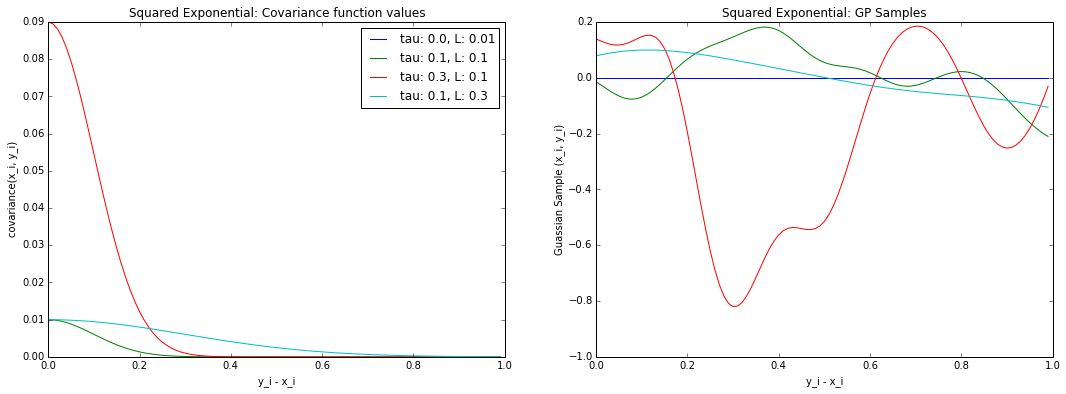

In [494]:
squared_exp_params = [(0.0, 0.01), (0.1, 0.1), (0.3, 0.1), (0.1, 0.3)]
plot_covar_fn("Squared Exponential", make_squared_exp_covar_fn, 
                  squared_exp_params, ['tau', 'L'])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


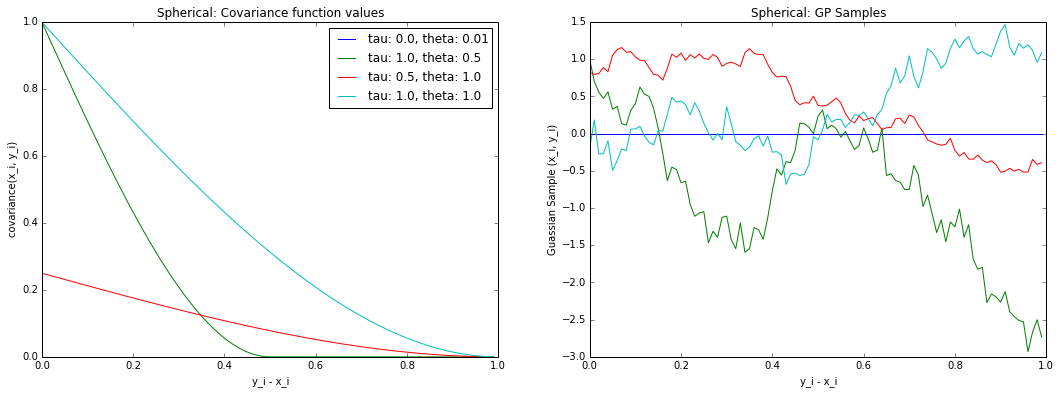

In [495]:
spherical_params = [(0.0, 0.01), (1.0, 0.5), (0.5, 1.0), (1.0, 1.0)]
plot_covar_fn("Spherical", make_spherical_covar_fn, 
              spherical_params, ['tau', 'theta'])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


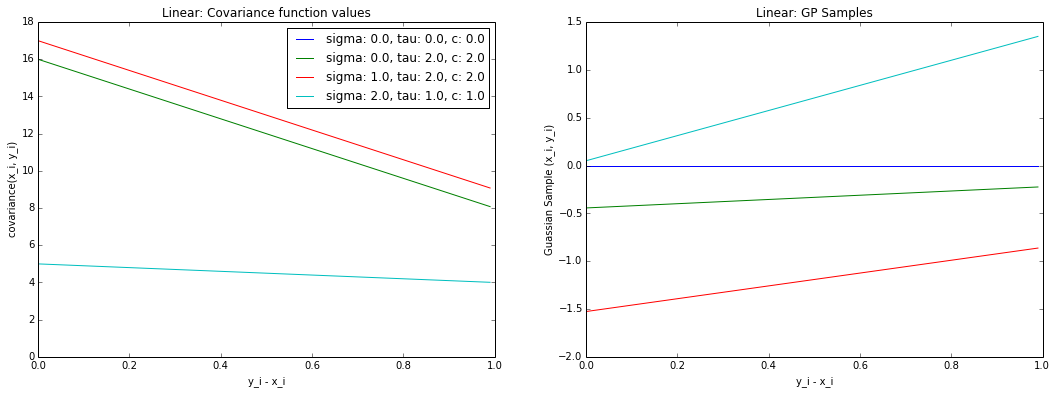

In [496]:
linear_param_list = [(0.0, 0.0, 0.0), (0.0, 2.0, 2.0), (1.0, 2.0, 2.0), (2.0, 1.0, 1.0)]
plot_covar_fn("Linear", make_linear_covar_fn, linear_param_list, ['sigma', 'tau', 'c'])